# Big Data Analytics Final Project

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("Speed Dating Data.csv", encoding = 'ISO-8859-1')
data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


## Pre-Processing

In [3]:
#Remove variables that were recorded AFTER the matches were sent. Because these variables were surveyed after 
#our response variable, they are fundamentally useless
data = data.drop(data.columns[156:195], axis = 1)

In [4]:
#Removed entries of parameter 'wave'. Waves 6-9 were removed due to having differing rating parameters than the rest of the data

data = data[data['wave'] != 12]
data = data[(data['wave'] < 5) | (data['wave'] > 9)]

I removed rows that fell under wave 5-9 because the people in that wave had to grade in a different scale than the rest of the dataset and therefore it would affect our modelling if kept in.

I removed the participants in row 12 could only 'match' with up to 50% of the people they speed dated, there was an implicit bias before they were even surveyed and their wave was unique to every other wave

Removal of Trivial Variables based on Documentation

In [5]:
#Remove trivial/not useful variables based on information from the doc
data = data.drop(['iid','id','idg','condtn','round','position','positin1','order','partner','pid','undergra',
                'mn_sat','tuition','from','zipcode','income','field_cd','career_c','attr4_1','sinc4_1','intel4_1',
                'fun4_1','amb4_1','shar4_1','attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1','attr3_1',
                 'sinc3_1','fun3_1','intel3_1','amb3_1','attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1','dec','like',
                'prob','met','match_es','attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s',
                'sinc3_s','intel3_s','fun3_s','amb3_s','attr7_2','sinc7_2','intel7_2','fun7_2','amb7_2','shar7_2',
                'attr4_2','sinc4_2','intel4_2','fun4_2','amb4_2','shar4_2','attr2_2','sinc2_2','intel2_2','fun2_2',
                 'amb2_2','shar2_2','attr5_2','sinc5_2','intel5_2','fun5_2','amb5_2','expnum', 'prob_o','like','like_o'], axis=1)

### Dealing with Missing Values

Use this code to check if there are any na or missing values in your dataset

In [8]:
#data.isnull().sum().sum() #-> Total number of missing values
#data.isnull().sum() #-> Missing values by column

17818

For categorical variables I decided to just omit rows with missing values

In [9]:
data = data.dropna(subset=['race_o','race','field','career'])
data = data.drop(columns = ['field', 'career', 'dec_o'])

For numerical variables I decided to perform an imputation, replacing missing cells with the median of the column as I felt that would be better than outright dropping the rows

In [11]:
c = data.select_dtypes(np.number).columns
data[c] = data[c].fillna(data[c].median())

## Train-Test Split (70-30)

In [12]:
import sklearn.model_selection as ms

In [13]:
Y = data['match']
X = data.drop(['match','wave'], axis = 1)

In [14]:
XTrain, XTest, YTrain, YTest = ms.train_test_split(X, Y, test_size= 0.3, random_state=1)

## Creating a Decision Tree

In [15]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

#Creating parameters for the grid search and instantiating the tree model
depth_val = np.arange(2, 11)
leaf_val = np.arange(1, 51, step = 2)

grid_space = [{'max_depth': depth_val, 'min_samples_leaf': leaf_val}]
tree_model = tree.DecisionTreeClassifier()

cv_tree = GridSearchCV(estimator = tree_model, param_grid = grid_space, cv = ms.KFold(n_splits = 3))

#Fitting the model and finding best parameters for it
cv_tree.fit(XTrain, YTrain)

display(cv_tree.best_params_)

best_depth = cv_tree.best_params_['max_depth']
best_min_samples = cv_tree.best_params_['min_samples_leaf']

#Creating a new model using the best parameters
best_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = best_depth, min_samples_leaf = best_min_samples)
matchTree = best_tree.fit(XTrain, YTrain)

{'max_depth': 4, 'min_samples_leaf': 41}

### Exporting the tree model

In [16]:
tree.export_graphviz(matchTree, out_file = 'MatchTree.dot', max_depth = best_depth, feature_names = X.columns, class_names = ['Match', 'No_Match'])

## Confusion Matrix for Accuracy and Prediction

In [20]:
from sklearn import metrics

#Creating predictions using the tree model on the testing data
match_prediction = matchTree.predict(XTest)

match_proba = matchTree.predict_proba(XTest)

#Here, a basic confusion matrix was created to assess model accuracy
confusion_mat = metrics.confusion_matrix(YTest, match_prediction)
display(confusion_mat)

acc_score = (confusion_mat[0, 0] + confusion_mat[1, 1]) / (confusion_mat[0, 0] + confusion_mat[0, 1] + confusion_mat[1, 0]
                                                          + confusion_mat [1, 1])
print('The accuracy of the tree model in predicting a match is: ', acc_score)

array([[1473,   53],
       [ 208,   97]], dtype=int64)

The accuracy of the tree model in predicting a match is:  0.8574549426542872


### Confusion Matrix and Classification Report

In [21]:
from sklearn.metrics import classification_report
print(classification_report(YTest, match_prediction))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1526
           1       0.65      0.32      0.43       305

    accuracy                           0.86      1831
   macro avg       0.76      0.64      0.67      1831
weighted avg       0.84      0.86      0.84      1831



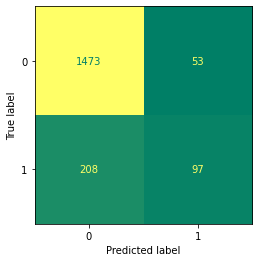

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = ConfusionMatrixDisplay.from_estimator(matchTree, XTest, YTest, colorbar = False, cmap = 'summer')

### Feature Importance

In [17]:
import itertools 
import matplotlib.pyplot as plt

#We can use the itertools module to find the importance of each feature by percent contribution to the model
importances = matchTree.feature_importances_
columns = X.columns

#Looping thru the model to get the percentage for each individual variable
i=0
while i < len(columns):
    print(f" The importance of feature ' {columns[i]}' is {round(importances[i] * 100,2)}%.")
    i += 1

 The importance of feature ' gender' is 0.0%.
 The importance of feature ' int_corr' is 0.0%.
 The importance of feature ' samerace' is 0.0%.
 The importance of feature ' age_o' is 1.88%.
 The importance of feature ' race_o' is 0.0%.
 The importance of feature ' pf_o_att' is 0.0%.
 The importance of feature ' pf_o_sin' is 0.0%.
 The importance of feature ' pf_o_int' is 0.0%.
 The importance of feature ' pf_o_fun' is 1.41%.
 The importance of feature ' pf_o_amb' is 0.0%.
 The importance of feature ' pf_o_sha' is 1.25%.
 The importance of feature ' attr_o' is 13.69%.
 The importance of feature ' sinc_o' is 0.0%.
 The importance of feature ' intel_o' is 0.0%.
 The importance of feature ' fun_o' is 34.15%.
 The importance of feature ' amb_o' is 0.0%.
 The importance of feature ' shar_o' is 2.36%.
 The importance of feature ' met_o' is 0.0%.
 The importance of feature ' age' is 0.0%.
 The importance of feature ' race' is 0.0%.
 The importance of feature ' imprace' is 0.0%.
 The importance o

#### As we can we can see from the tree and feature importance list, by far the 3 most important features were how funny daters viewed their partner, and how attractive a person viewed themselves as well as their partner.

#### We can draw many insights just from this to extrapolate to any dating scene or app, such as that humor appears to be the most important factor for either gender in a partner, and that confidence (through one's self-attraction rating) is as important as attraction towards your partner